In [2]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
import random
import pandas as pd
import numpy as np
import pickle


os.chdir('../raw_data')


#### Functions to load and or write to pickle files

In [3]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [4]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()[:2000] #just a subset for scripting
df_all.shape

(2000, 8)

In [41]:
class DeepCCA:
    def __init__(self, df_all,batch_size = 700,num_workers = 6,\
                latent_dims=50, epochs=300, lr=0.001):
        
        self.df_all = df_all
        self.batch_size = 100#batch_size
        self.num_workers = num_workers
        self.v1='ms2ds'
        self.v2 = 'mol2vec'
        
        self.epochs = epochs
        self.lr = lr
        self.latent_dims=latent_dims
        self.optim = 'sgd'
        self.objective = objectives.CCA
        self.layer_size = (500,300,300)
        
        
    def split_data(self,test_size=0.2,\
                   random_state=None,stratify=None):
        
        if random_state != None and stratify == None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=random_state)
        
        elif random_state == None and stratify != None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size,stratify=self.df_all[stratify])
        else:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=42)
        
        return train_df, test_df 
    
    def gen_views(self,v1='ms2ds',v2='mol2vec'):
        
        #split test, train
        train_df,test_df= self.split_data(test_size=0.2,random_state=42)
        
        #Split train dataset into train and validation set
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
        
        
        #extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
        v1_train, v1_test = np.array([x for x in train_df[v1]]), np.array([x for x in test_df[v1]])
        v2_train, v2_test = np.array([x for x in train_df[v2]]), np.array([x for x in test_df[v2]])

        # validation
        v1_val, v2_val = np.array([x for x in val_df[v1]]), np.array([x for x in val_df[v2]])
        
        #update self dfs
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        
        # not memory efficient !!!
        self.v1_train, self.v1_test = v1_train, v1_test
        self.v2_train, self.v2_test = v2_train, v2_test
        self.v1_val, self.v2_val = v1_val, v2_val
        
        return None
    
    def deepcca_encoders(self):
        # define encoders
        self.encoder_1 = architectures.Encoder(latent_dims = self.latent_dims, \
                                      feature_size = self.v1_size,\
                                      layer_sizes = self.layer_size
                                    )
                                     
        self.encoder_2 = architectures.Encoder(latent_dims=self.latent_dims, \
                                      feature_size=self.v2_size, \
                                      layer_sizes=self.layer_size
                                     )
       
        return None#[encoder_1, encoder_2]
        
    
    def deepcca_dataloaders(self):
        
        #v1_train,v1_test, v2_train,v2_test, v1_val, v2_val = \
        self.gen_views(v1=self.v1, v2=self.v2)
        
        #creat CCA dataset 
        train_dataset = CCA_Dataset([self.v1_train, self.v2_train])
        test_dataset = CCA_Dataset([self.v1_test, self.v2_test])
        val_dataset = CCA_Dataset([self.v1_val, self.v2_val])
        
        #update features size
        self.v1_size = self.v1_train.shape[1]
        self.v2_size = self.v2_train.shape[1]
        self.N = len(train_dataset)
        
        #set N (for sdl; equal len train dataset)
        self.N = len(train_dataset)
        
        #loaders
        self.train_loader , self.val_loader = get_dataloaders(train_dataset, \
                                                    val_dataset,batch_size=self.batch_size,\
                                                    num_workers=self.num_workers,drop_last=False)
        self.test_loader = get_dataloaders(test_dataset,\
                                      batch_size=self.batch_size, \
                                      num_workers=self.num_workers,drop_last=False)
        
        
        
        
        return None
    
    
    def train_cca(self): #only for comparison with other deep models
        
       
        
        #define and train cca model
        print('\n','-'*20,'\n Training CCA\n','-'*20)
        cca = CCA(latent_dims=self.latent_dims).fit((self.v1_train, self.v2_train))
        self.cca = cca
        return None#cca
    
    def train_sdl(self,lam=0.0001):
        
        #encoders = self.deepcca_encoders()
        
        # 2. SDL
        sdl = DCCA_SDL(self.latent_dims,
                       optimizer=self.optim,
                       N=self.N, 
                       encoders = [self.encoder_1,self.encoder_2],
                       lam=0.0001, 
                       lr=self.lr,
                       objective=self.objective) 

        #train
        trainer = pl.Trainer(max_epochs=self.epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

        print('\n','-'*20,'\n Training SDL\n','-'*20)
        trainer.fit(sdl, self.train_loader,self.val_loader)
        self.sdl = sdl
        return None#sdl
    
    def train_dcca(self):
        
        encoders = self.deepcca_encoders() 
        
        # 2. DCCA
        dcca = DCCA(self.latent_dims,
                    optimizer=self.optim,
                    encoders = [self.encoder_1,self.encoder_2],
                    lr=self.lr,
                    objective=self.objective) 

        #train
        trainer = pl.Trainer(max_epochs=self.epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

        print('\n','-'*20,'\n Training DCCA\n','-'*20)
        trainer.fit(dcca, self.train_loader,self.val_loader)
        
        self.dcca = dcca
        
        return None #dcca
    
    
    
    def score(self,model,dataset): 
        """
        model: either 'cca', 'dcca', 'sdl'
        dataset: 'train', 'test', or 'val'
        """
       # for cca models 
        #m = eval(model)
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        if model == 'cca':
            corr = self.cca.score([v1,v2])
        
        if model == 'sdl':
            corr = self.sdl.score(loader)
        
        elif model == 'dcca':
            corr = self.dcca.score(loader)
       
        return corr
    def update_z_scores(self,dataset, z1,z2,cols):
        #update train df with transformed z scores
            if dataset == 'train':
                
                self.train_df[cols[0]] = [x for x in z1]
                self.train_df[cols[1]] = [x for x in z2]
                
            #update test df
            if dataset == 'test':
                self.test_df[cols[0]] = [x for x in z1]
                self.test_df[cols[1]] = [x for x in z2]
            
            #update val df
            if dataset == 'val':
                self.val_df[cols[0]] = [x for x in z1]
                self.val_df[cols[1]] = [x for x in z2]
            return None
                
        
    
    def transform(self,model,dataset):
        """
        model: either 'cca', 'dcca', 'sdl': of course the model must have been fitted :)
        cca_data: [view1, view2] for cca
        loader: is similar data loader used to train either sdl/dcca
        dataset: either 'train', 'test', 'val'
        
        returns transformed data; view1,view2
        """
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        
        #specify the model for transformation
        if model == 'cca':
            z1,z2 = self.cca.transform([v1,v2]) #transform
            self.update_z_scores(dataset,z1,z2,cols=['cca_z1','cca_z2']) # update the df with z scores            
    
            
        if model == 'sdl':
            z1,z2 = self.sdl.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['sdl_z1','sdl_z2'])
                
        
        if model == 'dcca':
            z1,z2 = self.dcca.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['dcca_z1','dcca_z2'])
        
        
        return None##z1,z2; can be found in self.<df[model_z]>
            
    
            
        

In [6]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
# df_all.shape

In [42]:
# Initiate deepcca objec
Models = DeepCCA(df_all)

# generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

In [36]:

# train cca
Models.train_cca() # will look at this for opti

# score the models: it runs cca.score

cca_train_corr = Models.score(model='cca', dataset='train')
cca_test_corr  = Models.score(model='cca', dataset='test')

#cca transform: runs cca.transform and update the df with z scores
Models.transform(model='cca', dataset='train')
Models.transform(model='cca', dataset='test')



 -------------------- 
 Training CCA
 --------------------


In [38]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/
# train sdl
Models.train_sdl() # will look at this for opti

# score the models: it runs sdl.score()

sdl_train_corr =Models.score(model='sdl', dataset='train')
sdl_test_corr = Models.score(model='sdl', dataset='test')

#sdl transform: runs sdl.transform and update the df with z scores
Models.transform(model='sdl', dataset='train')
Models.transform(model='sdl', dataset='test')


Reusing TensorBoard on port 6006 (pid 14384), started 0:53:48 ago. (Use '!kill 14384' to kill it.)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/
# train dcca
Models.train_dcca() # will look at this for opti

# score the models: it runs dcca.score()

sdl_train_corr =Models.score(model='dcca', dataset='train')
sdl_test_corr = Models.score(model='dcca', dataset='test')

#dcca transform: runs dcca.transform and update the df with z scores
Models.transform(model='dcca', dataset='train')
Models.transform(model='dcca', dataset='test')


Reusing TensorBoard on port 6006 (pid 14384), started 1:12:10 ago. (Use '!kill 14384' to kill it.)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training DCCA
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [98]:
deepcca.train_df.shape

AttributeError: 'DeepCCA' object has no attribute 'train_df'

In [49]:
v1_train

array([[48.32883453,  1.34241104, 18.15781403, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  4.56520271, 20.90509033, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 11.33115196,  0.        , ...,  7.05778646,
         0.        , 15.06133175],
       ...,
       [ 0.        , 19.76557159, 13.89834976, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        26.22119141,  0.        ],
       [ 0.        ,  0.        , 14.51716995, ...,  0.        ,
        34.4786911 , 11.61527348]])

In [80]:

#train sdl
sdl = deepcca.train_sdl(train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026E9B74B8B0>
Traceback (most recent call last):
  File "C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1469, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1410, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (self._persistent_workers and s

In [87]:
#train sdl
dcca = deepcca.train_dcca(train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [51]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.2, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [52]:
#creat CCA dataset 
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])



batch_size = 700
train_loader , val_loader = get_dataloaders(train_dataset, \
                                            val_dataset,batch_size=batch_size,\
                                           num_workers=6,drop_last=False)
test_loader = get_dataloaders(test_dataset,\
                              batch_size=batch_size, \
                              num_workers=6,drop_last=False)

In [56]:
#code is still a mess: STRUCTURE!!!
#params
N = len(train_dataset)
latent_dims = 50
epochs = v2_train.shape[1]
lr = 0.001
#optimizer = optim.SGD(lr=0.01, momentum=0.9)



print('\n','-'*20,'\n Training CCA\n','-'*20)
cca = CCA(latent_dims=latent_dims).fit((v1_train, v2_train))# train cca as well for comparison

# define encoders
encoder_1 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v1_train.shape[1],\
                                  layer_sizes=(500,300,300)
                                )
                                     
encoder_2 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v2_train.shape[1], \
                                  layer_sizes=(500,300,300)
                                 )



 -------------------- 
 Training CCA
 --------------------


In [25]:
#extract cca correlation
cca_train_corr = cca.score([v1_train, v2_train])
cca_test_corr = cca.score([v1_val, v2_val])

NameError: name 'v1_train' is not defined

In [58]:
# generate cca train projections
train_cca_z1, train_cca_z2 = cca.transform([v1_train, v2_train])
train_df['cca_z1'] = [x for x in train_cca_z1]
train_df['cca_z2'] = [x for x in train_cca_z2]

In [59]:
# # generate cca test projections
test_cca_z1, test_cca_z2 = cca.transform([v1_test, v2_test])
test_df['cca_z1'] = [x for x in test_cca_z1]
test_df['cca_z2'] = [x for x in test_cca_z2]

In [60]:
# generate cca val projections
val_cca_z1, val_cca_z2 = cca.transform([v1_val, v2_val])
val_df['cca_z1'] = [x for x in val_cca_z1]
val_df['cca_z2'] = [x for x in val_cca_z2]

In [154]:
%%time
#  # 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=lr)

 # Define the trainer
#dcca
dcca_trainer = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,\
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="val/objective")])

#train
print('\n','-'*20,'\n Training DCCA\n','-'*20)
dcca_trainer.fit(dcca, train_loader,val_dataloaders=val_loader)



# # generate dcca train projections
# train_loader, val_loader  = get_dataloaders(train_dataset,val_dataset,\
#                                             batch_size=batch_size,drop_last=False)
                                            
train_z1, train_z2 = dcca.transform(train_loader)
train_df['dcca_z1'] = [x for x in train_z1]
train_df['dcca_z2'] = [x for x in train_z2]

# generate dcca test projections

test_z1, test_z2 = dcca.transform(test_loader)
test_df['dcca_z1'] = [x for x in test_z1]
test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = dcca.transform(val_loader)
val_df['dcca_z1'] = [x for x in val_z1]
val_df['dcca_z2'] = [x for x in val_z2]

#score
dcca_train_corr = dcca.score(train_loader)
dcca_test_corr = dcca.score(test_loader)

In [153]:
%%time
# 2. SDL
sdl = DCCA_SDL(latent_dims,optimizer='sgd',
                N=N, encoders=[encoder_1, encoder_2],
                lam=0.0001, lr=lr,
                objective=objectives.CCA) # train size

#train
trainer_sdl = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

print('\n','-'*20,'\n Training SDL\n','-'*20)
trainer_sdl.fit(sdl, train_loader,val_loader)



train_z1, train_z2 = sdl.transform(train_loader)
train_df['sdl_z1'] = [x for x in train_z1]
train_df['sdl_z2'] = [x for x in train_z2]

# generate dcca test projections
#test_loader = get_dataloaders(test_dataset)#,batch_size=batch_size,drop_last=False)#,batch_size=batch_size)
test_z1, test_z2 = sdl.transform(test_loader)
test_df['sdl_z1'] = [x for x in test_z1]
test_df['sdl_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = sdl.transform(val_loader)
val_df['sdl_z1'] = [x for x in val_z1]
val_df['sdl_z2'] = [x for x in val_z2]

#score
sdl_train_corr = sdl.score(train_loader)
sdl_test_corr = sdl.score(test_loader)


In [63]:
# To construct image name
embedding = 'MS2DeepScore'
method = 'ALL_3_hidden'
data = 'max3'
dims = latent_dims

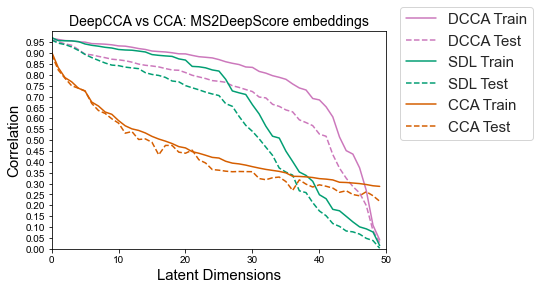

In [64]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]] 

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                      'SDL Train', 'SDL Test',\
                      'CCA Train', 'CCA Test'], \
                       loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, latent_dims)

plt.yticks(np.arange(0, 1, step=0.05))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

#there is problem: sdl and dcca certanly will not be that close

In [152]:
#write dfs (with the z score from dcca,cca and sdl) to file

dfs = [train_df,test_df,val_df]

paths = ['./max3_train_df_with_z.pickle',
        './max3_test_df_with_z.pickle',
        './max3_val_df_with_z.pickle']

for df, path in zip(dfs,paths):
    Files(path).write_to_file(df)
    

### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:(using euc only for now since its faster)

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [66]:
def predict(subject_df,query_df,\
            method,dims,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(query_df[f'{method}_z1']): #(query z1)
        
        #calculate tanimotos if it does not meet threshold;pass
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    
    return preds
    

In [67]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [68]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [69]:
# function to calculate tanimoto scores for n hits returns a max tanimotos and {query:top_hit}
def get_tanimotos(preditions_dict,\
                  subject_df,query_df, metric,nn=100):
    tanimotos = []
    pred = {} #key is the query index, value is the top hit index
    
    for query_index, values in preditions_dict.items(): # values == score(corr, euc or cosine)
        pred[query_index] = []
        
        #select top n hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:nn] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)]) #appends the index of the hit with highest tanimoto
            
        #select closest n hits for each query based on cosine/euclidian distance
        else: #may be elif metric != 'corr'
            top_hits = np.sort(values)[:nn] #if its euc or cos; the lower the better
    
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)])#appends the index of the hit with highest tanimoto
    return tanimotos, pred
    

In [70]:
def random_tanimoto(preditions_dict,
                subject_df,query_df):
    tanimotos = []
    
    for query_index, values in preditions_dict.items():
        subject_index = random.randint(0,len(values)) #randomly pick subject index as hits
        
        smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
        smile2 = query_df['smiles'].iloc[query_index]#extract the query smile 
        
        tanimotos.append(tanimoto(smile1,smile2))
    return tanimotos
        
        

In [16]:
%%time

dims = 25
#n=50
#nn=100
metric = 'euc'
#predict sdl euc
test_sdl_euc = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric=metric)
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl = get_tanimotos(test_sdl_euc, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric=metric)
# dcca
test_dcca_euc = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='dcca', metric=metric)
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca = get_tanimotos(test_dcca_euc, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric=metric)

#cca
test_cca_euc = predict(subject_df=train_df,\
                       query_df=test_df,dims=dims,\
                       method='cca',metric=metric)
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca = get_tanimotos(test_cca_euc, \
                       subject_df=train_df,\
                       query_df=test_df, \
                                       metric=metric)

#random tanimotos
random_tanimotos = random_tanimoto(test_cca_euc, \
                                       subject_df=train_df,\
                                       query_df=test_df)



In [17]:
eucs = [test_sdl_euc,test_dcca_euc,test_cca_euc]
hits = [hits_sdl,hits_dcca,hits_cca]
tanis = [test_sdl_euc_tanimotos,test_dcca_euc_tanimotos,test_cca_euc_tanimotos]




In [ ]:
paths = ['./max3_sdl_euc.pickle', './max3_dcca_euc.pickle','./max3_cca_euc.pickle']

for euc, path in zip(eucs,paths):
    Files(path).write_to_file(euc)

In [ ]:
paths = ['./max3_sdl_hits.pickle', './max3_dcca_hits.pickle','./max3_cca_hits.pickle']

for hit, path in zip(hits,paths):
    Files(path).write_to_file(hit)

In [ ]:
paths = ['./max3_sdl_tanimoto.pickle', './max3_dcca_tanimoto.pickle','./max3_cca_tanimoto.pickle']

for tan, path in zip(tanis,paths):
    Files(path).write_to_file(tan)

In [ ]:
#plot the distribution of the three top tanimotos from the three metrics
dist_list = [test_cca_euc_tanimotos,
             test_sdl_euc_tanimotos,
             test_dcca_euc_tanimotos,
            random_tanimotos]
for dist in dist_list:
    ax=sns.kdeplot(x=dist,shade=True)
plt.legend(labels=['CCA',
                   'SDL',
                   'DCCA',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

#### Draw Random predicted molecule

In [4]:
#os.listdir()

In [37]:
# load hits
paths = ['./max3_sdl_hits.pickle','./max3_dcca_hits.pickle','./max3_cca_hits.pickle']
hits_sdl = Files(paths[0]).load_pickle()
hits_dcca = Files(paths[1]).load_pickle()
hits_cca = Files(paths[2]).load_pickle()

In [71]:
#load dfs
paths = ['./max3_train_df_with_z.pickle',
        './max3_test_df_with_z.pickle',
        './max3_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
val_df = Files(paths[2]).load_pickle()


In [74]:
from rdkit import Chem
from rdkit.Chem import Draw

In [176]:
# function to extract the query and subject molecule, its legend(class_tanimoto_with the hit), can also return tanis
def pick_hit_mols(hits_dict, 
              train_df,test_df,group=None,
              return_tanimoto=False,k=2,filterby='inchikey14'): #if group == [cf_class], set filterby to 'cf_class'
    mols = []
    tanimoto = []
    classes = []
    for query_index, subject_index in  hits_dict.items():
    
    
        query_smile = test_df['smiles'].iloc[query_index]
        query_class = test_df['cf_class'].iloc[query_index]
        query_inchi = test_df['inchikey14'].iloc[query_index]
        
        if group:
            
            if filterby == 'cf_class':
                if query_class not in group:
                    continue
            else:
                if query_inchi not in group:
                    continue
    
        if type(query_class) == float:
            query_class = 'NAN'
            #classes = [f'Query:\t{query_class}',]
    
        classes.append(f'Query_{query_index}: {query_class}')#else
    
        query = Chem.MolFromSmiles(query_smile)
    
        subject_smile = train_df['smiles'].iloc[subject_index[0][0]]
        subject = Chem.MolFromSmiles(subject_smile)
        cl = train_df['cf_class'].iloc[subject_index[0][0]]
        if type(cl) == float:
            cl = 'NAN'
        subject_class = f'\tHit_{query_index}: {cl}:\tTanimoto: {subject_index[0][1]}'
        #print(query_class,subject_class)
        classes.append(subject_class)
        mols.append(query)
        mols.append(subject) #to expand later to include top 5 hits
        tanimoto.append(subject_index[0][1])
    
    
    if return_tanimoto:
        return mols, classes, tanimoto
    else:
        return mols, classes

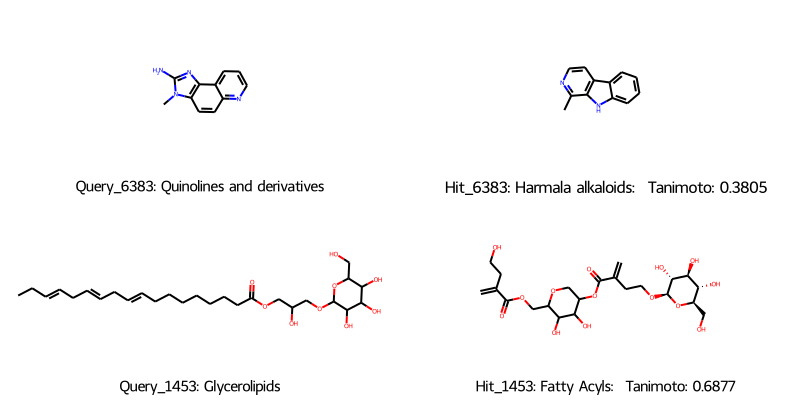

In [157]:
#randomly pick a query
keys = random.choices(list(hits_sdl.keys()),k=2)
subset_hits = {key: hits_sdl[key] for key in keys}

#draw the random queries plus their hits
sdl_random_mols, sdl_random_legends = pick_hit_mols(subset_hits,
                                                    train_df,test_df)
Draw.MolsToGridImage(sdl_random_mols,
                        molsPerRow=2, 
                        legends = sdl_random_legends,
                        subImgSize=(400,200),
                                returnPNG=True)


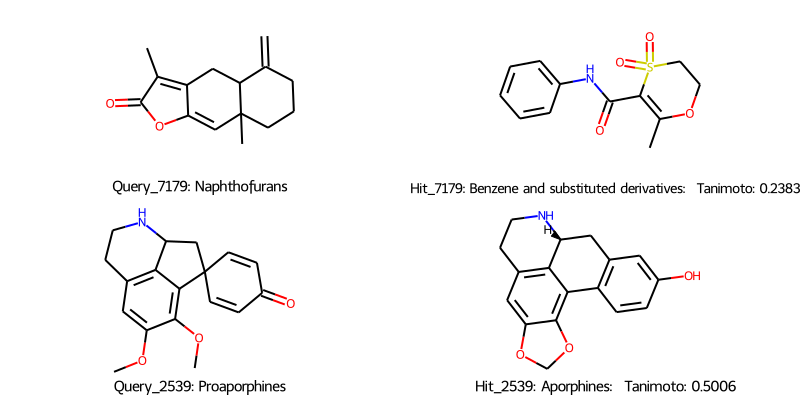

In [96]:

sdl_random_mols, sdl_random_legends = pick_hit_mols(subset_hits,
                                                    train_df,test_df)
Draw.MolsToGridImage(sdl_random_mols,
                        molsPerRow=2, 
                        legends = sdl_random_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

### Test how the model performs with classes appearing less than 2 times

In [167]:
# select classes appearing < 2 times in the train dataset
train_rare_classes = train_df.groupby('cf_class').filter(lambda x : 2 >= len(x))
train_rare_classes.shape

(75, 14)

In [181]:
# select classes appearing < 2 times in the test dataset
test_rare_classes = test_df.\
loc[test_df['cf_class'].isin([x for x in \
                                         train_rare_classes['cf_class']])]

test_rare_classes.shape

(30, 14)

In [182]:
test_rare_classes = random.choices([x for x in test_rare_classes['cf_class']],k=10)

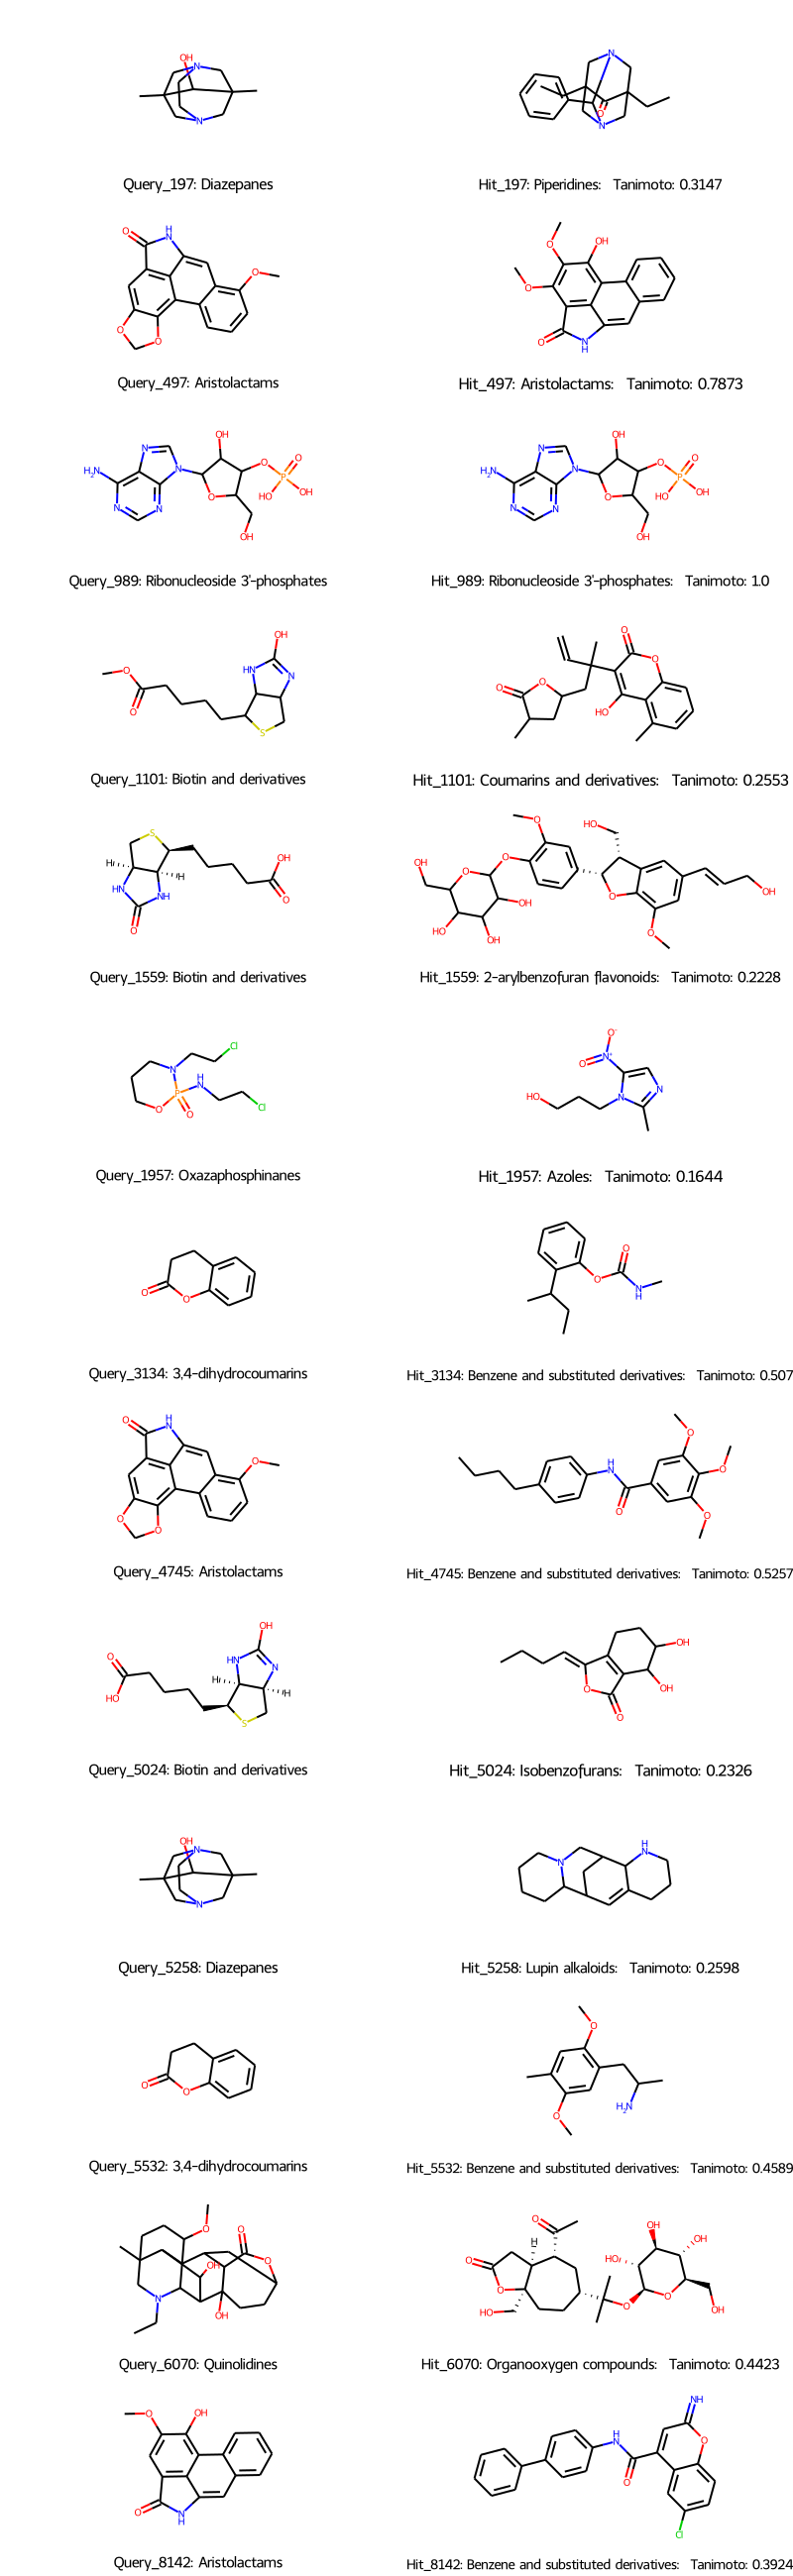

In [183]:
# sdl rare mols
sdl_rare_mols, sdl_rare_legends, sdl_rare_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          group=test_rare_classes,
                              return_tanimoto=True,filterby='cf_class')
Draw.MolsToGridImage(sdl_rare_mols,
                        molsPerRow=2, 
                        legends = sdl_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

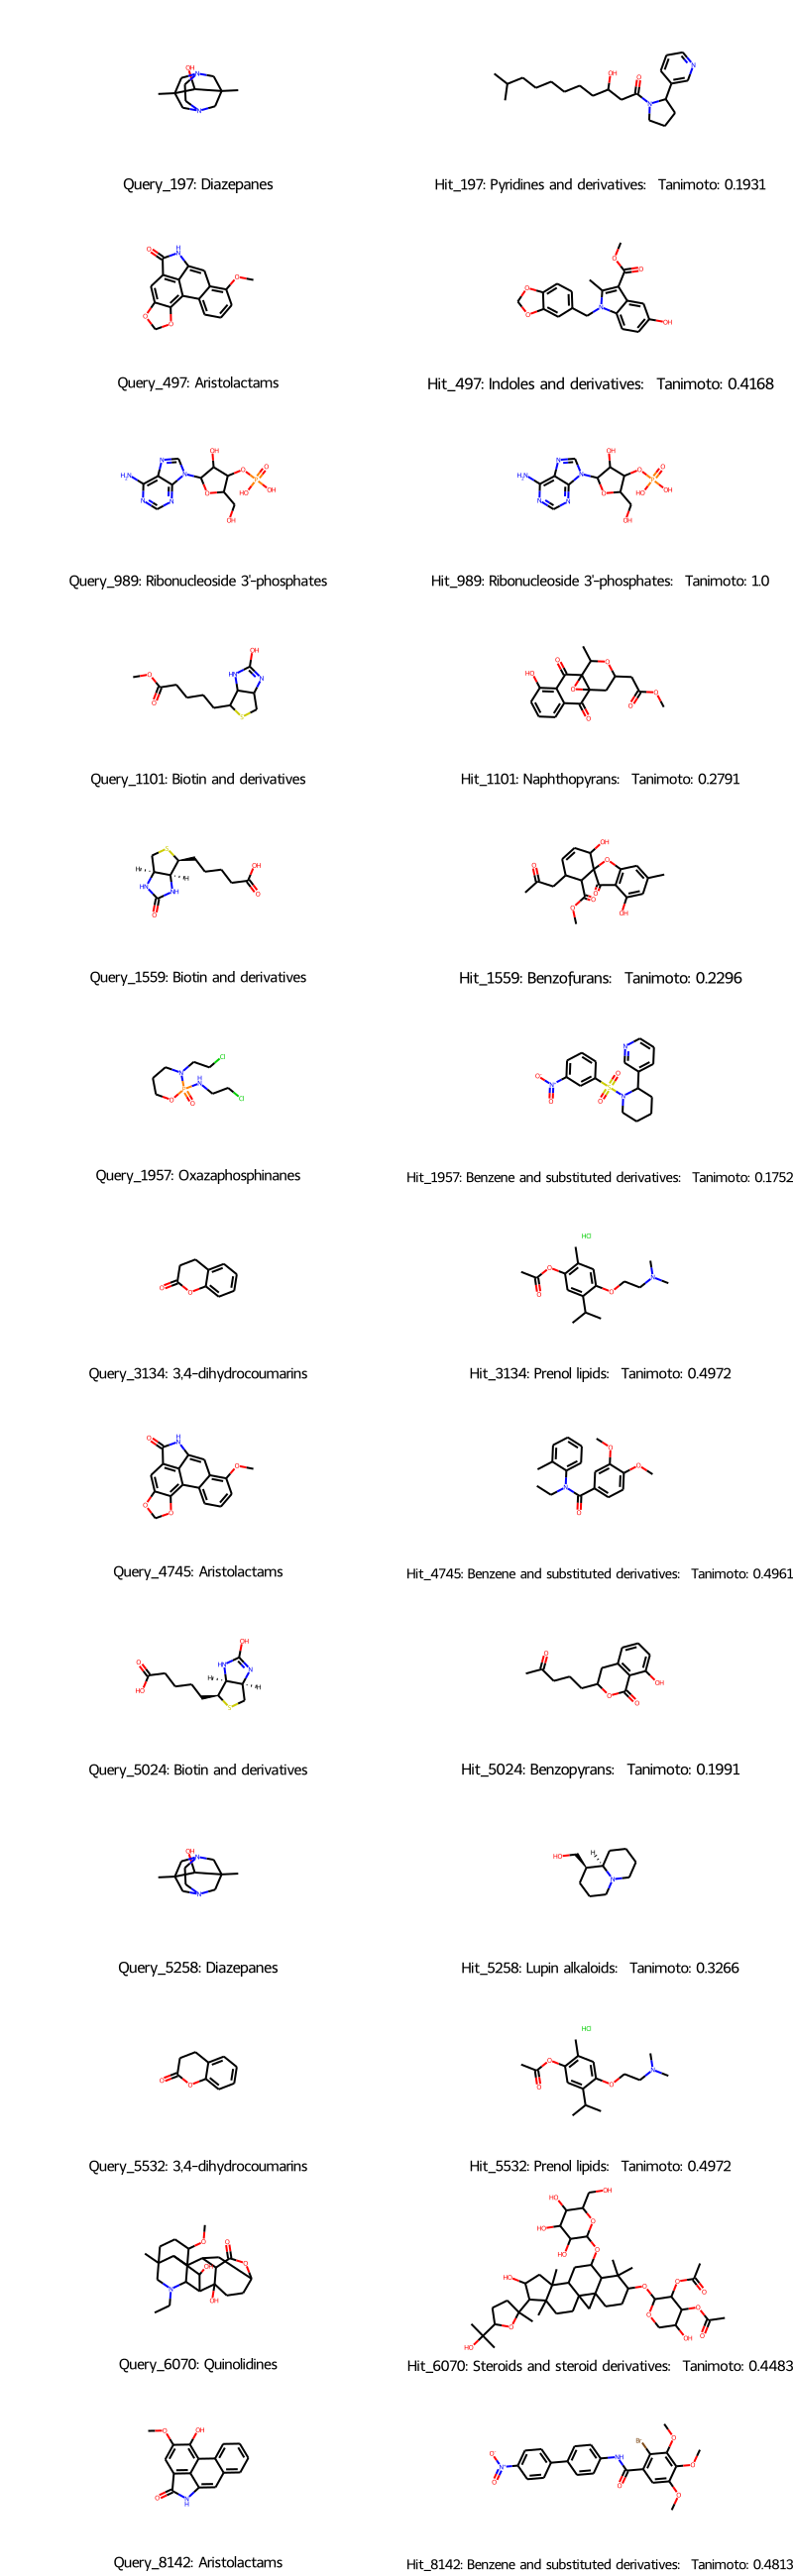

In [184]:
# cca rare mols
cca_rare_mols, cca_rare_legends, cca_rare_tanis = pick_hit_mols(hits_cca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(cca_rare_mols,
                        molsPerRow=2, 
                        legends = cca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

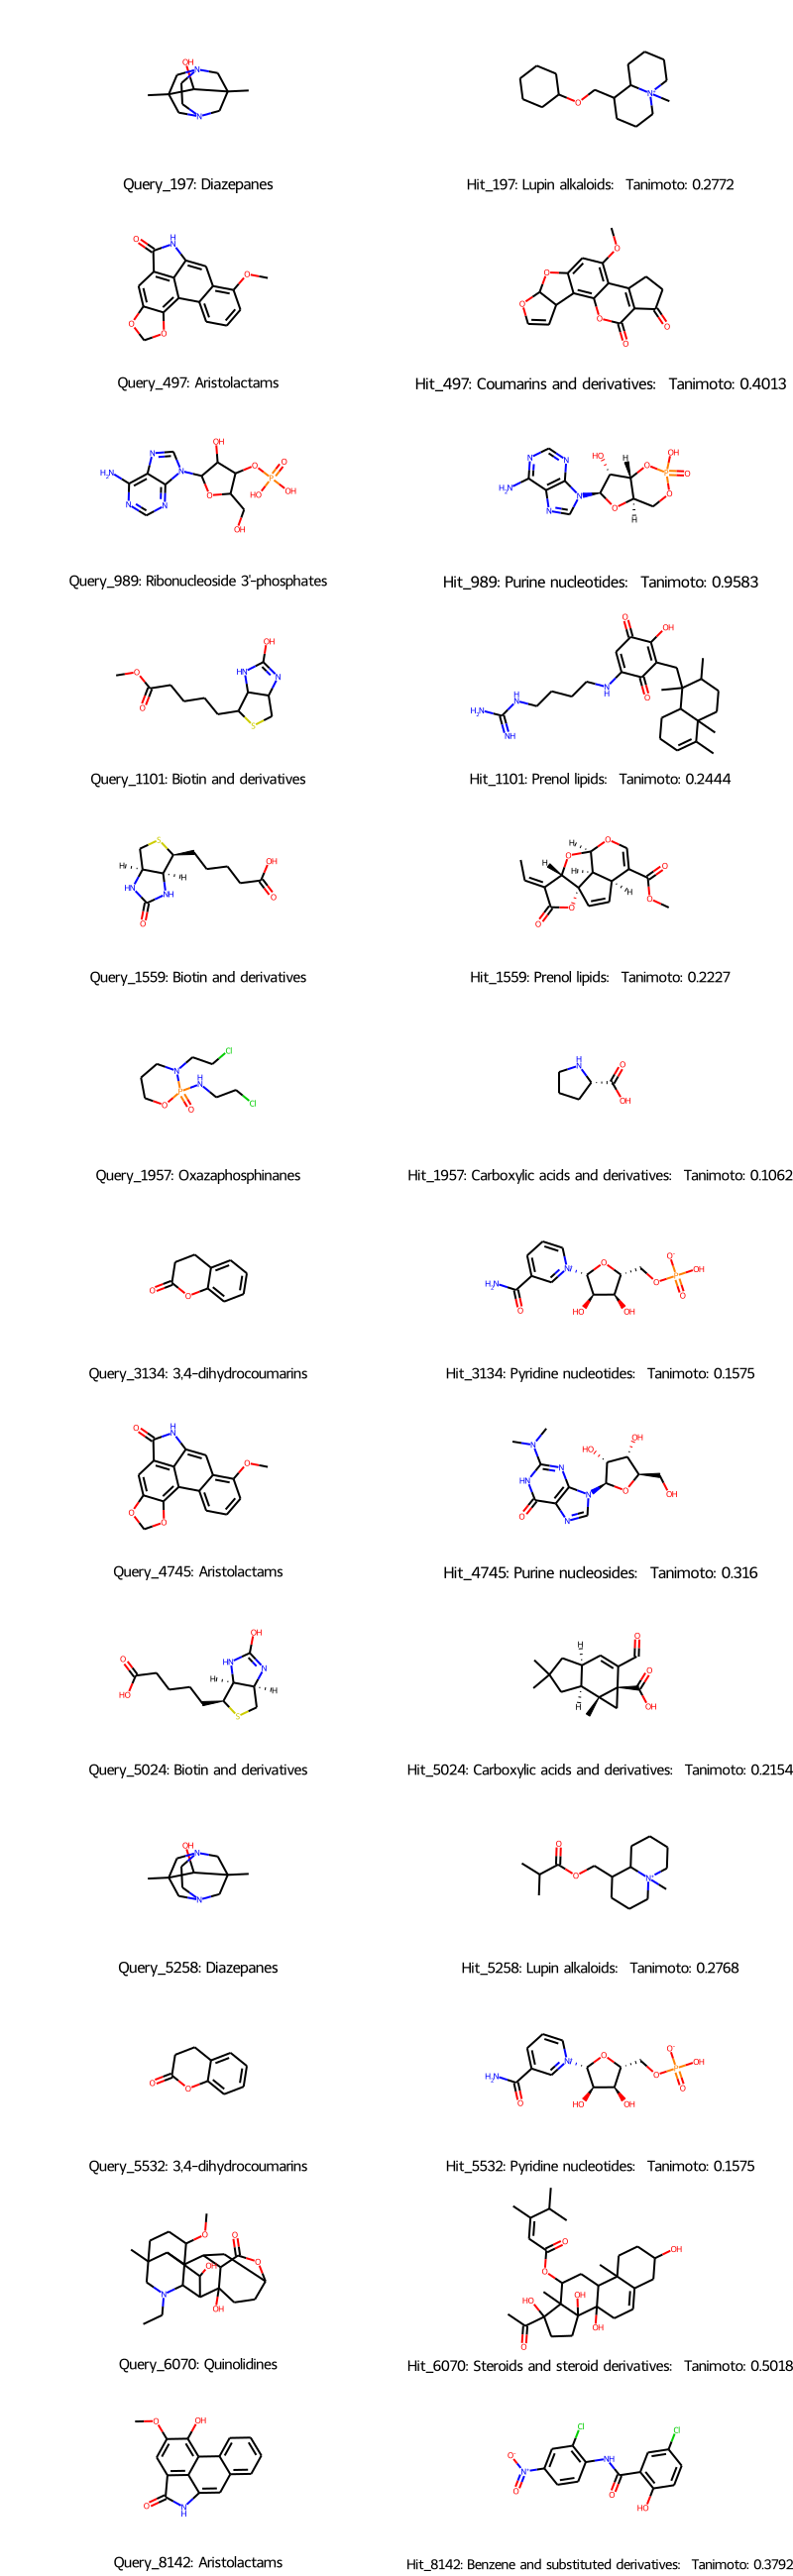

In [185]:
# dcca rare mols
dcca_rare_mols, dcca_rare_legends, dcca_rare_tanis = pick_hit_mols(hits_dcca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(dcca_rare_mols,
                        molsPerRow=2, 
                        legends = dcca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

In [145]:
#plot the distribution of the three top tanimotos from the three metrics
def plot_distribution(values, title,
                      legends=None,xlab=None,
                    ylab=None,
                     fig_path=None,
                     savefig=False):
    
    for val in values:
        ax=sns.kdeplot(x=val,shade=True)
    plt.legend(labels=legends, loc='center left', fontsize=12)
    plt.xlabel(xlab, fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.title(label=title, fontsize=15)
    
    if savefig and fig_path:
        plt.savefig(fig_path,\
               transparent=False,bbox_inches = 'tight')
    plt.show()

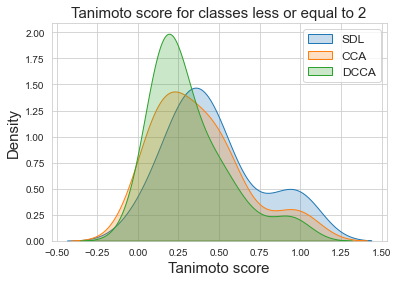

In [106]:
tanis = [sdl_rare_tanis,cca_rare_tanis,dcca_rare_tanis]
legends = ['SDL', 'CCA','DCCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for classes less or equal to 2'
fig_path = './rare_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                     fig_path=fig_path,
                     savefig=True)

#### Investigate if the models will always return true hits if it is in the subject dataset(database)

In [119]:
# select inchikey14 occuring both in test(query) and train(subject) 
common_inchikeys = train_df.groupby('inchikey14').filter(lambda x : len(x)>=2)
common_inchikeys.shape

(24230, 14)

In [120]:
common_chi_list = [x for x in common_inchikeys['inchikey14']]

In [158]:
test_common_ichi= test_df.\
loc[test_df['inchikey14'].isin(common_chi_list)]
test_common_ichi.shape

test_common_list = random.choices([x for x in test_common_ichi['inchikey14']],k=10)# sample a few to draw structures

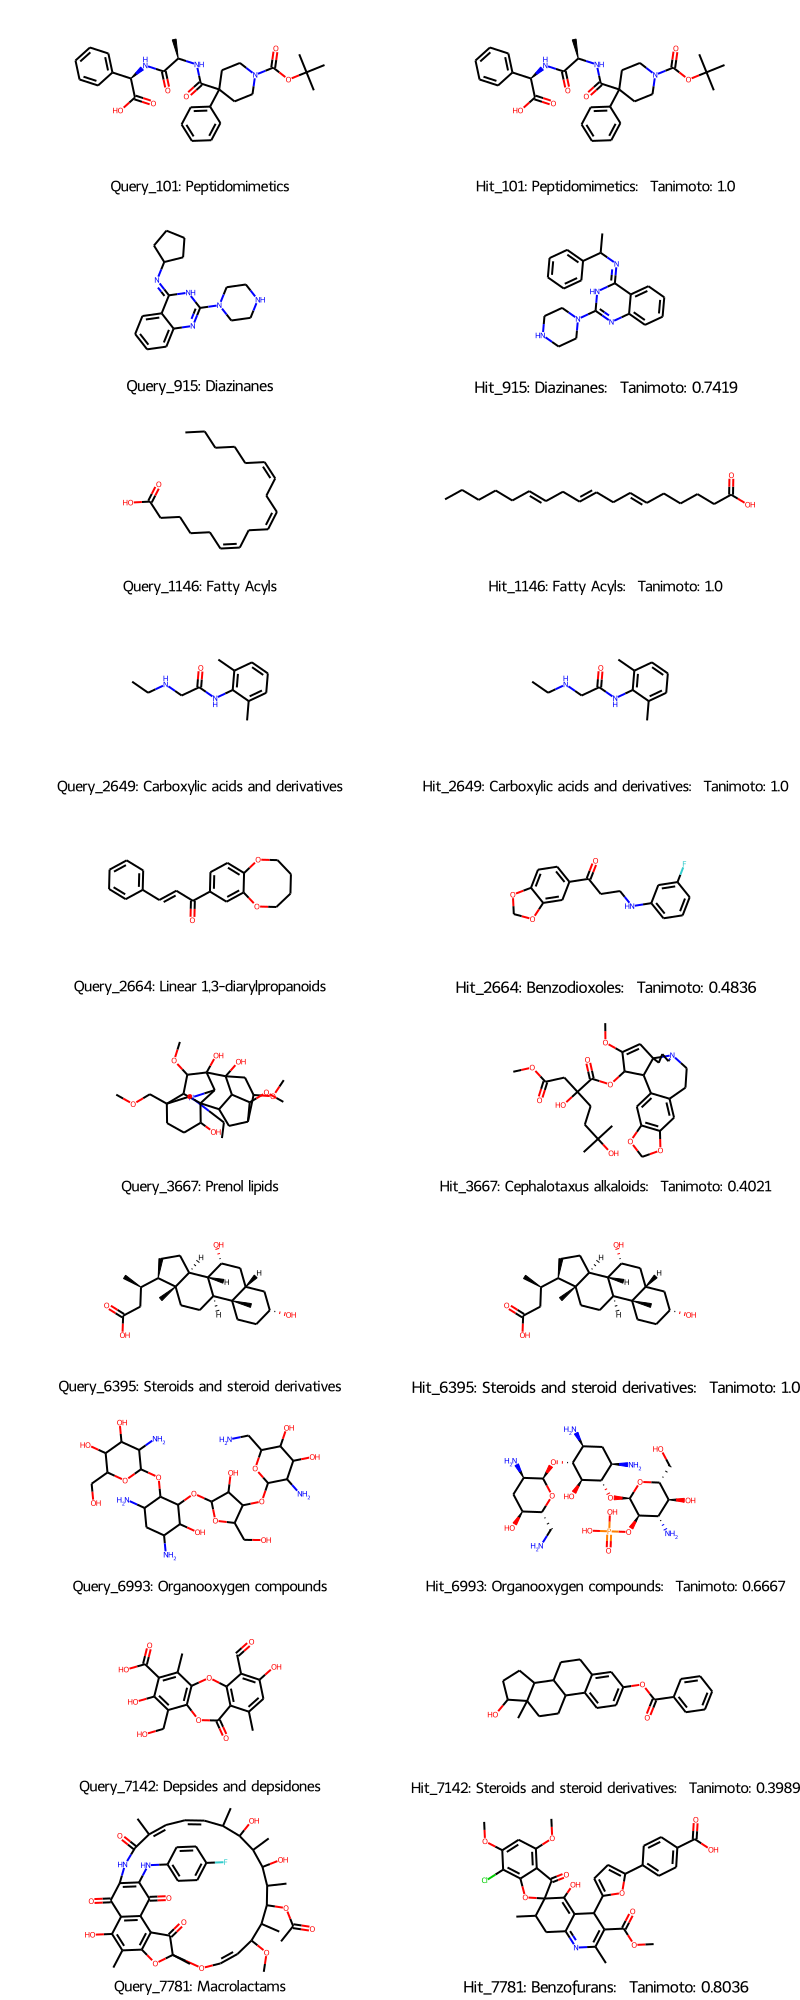

In [159]:
# sdl common mols
sdl_common_mols, sdl_common_legends, sdl_common_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          group=test_common_list,
                              return_tanimoto=True)
Draw.MolsToGridImage(sdl_common_mols,
                        molsPerRow=2, 
                        legends = sdl_common_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

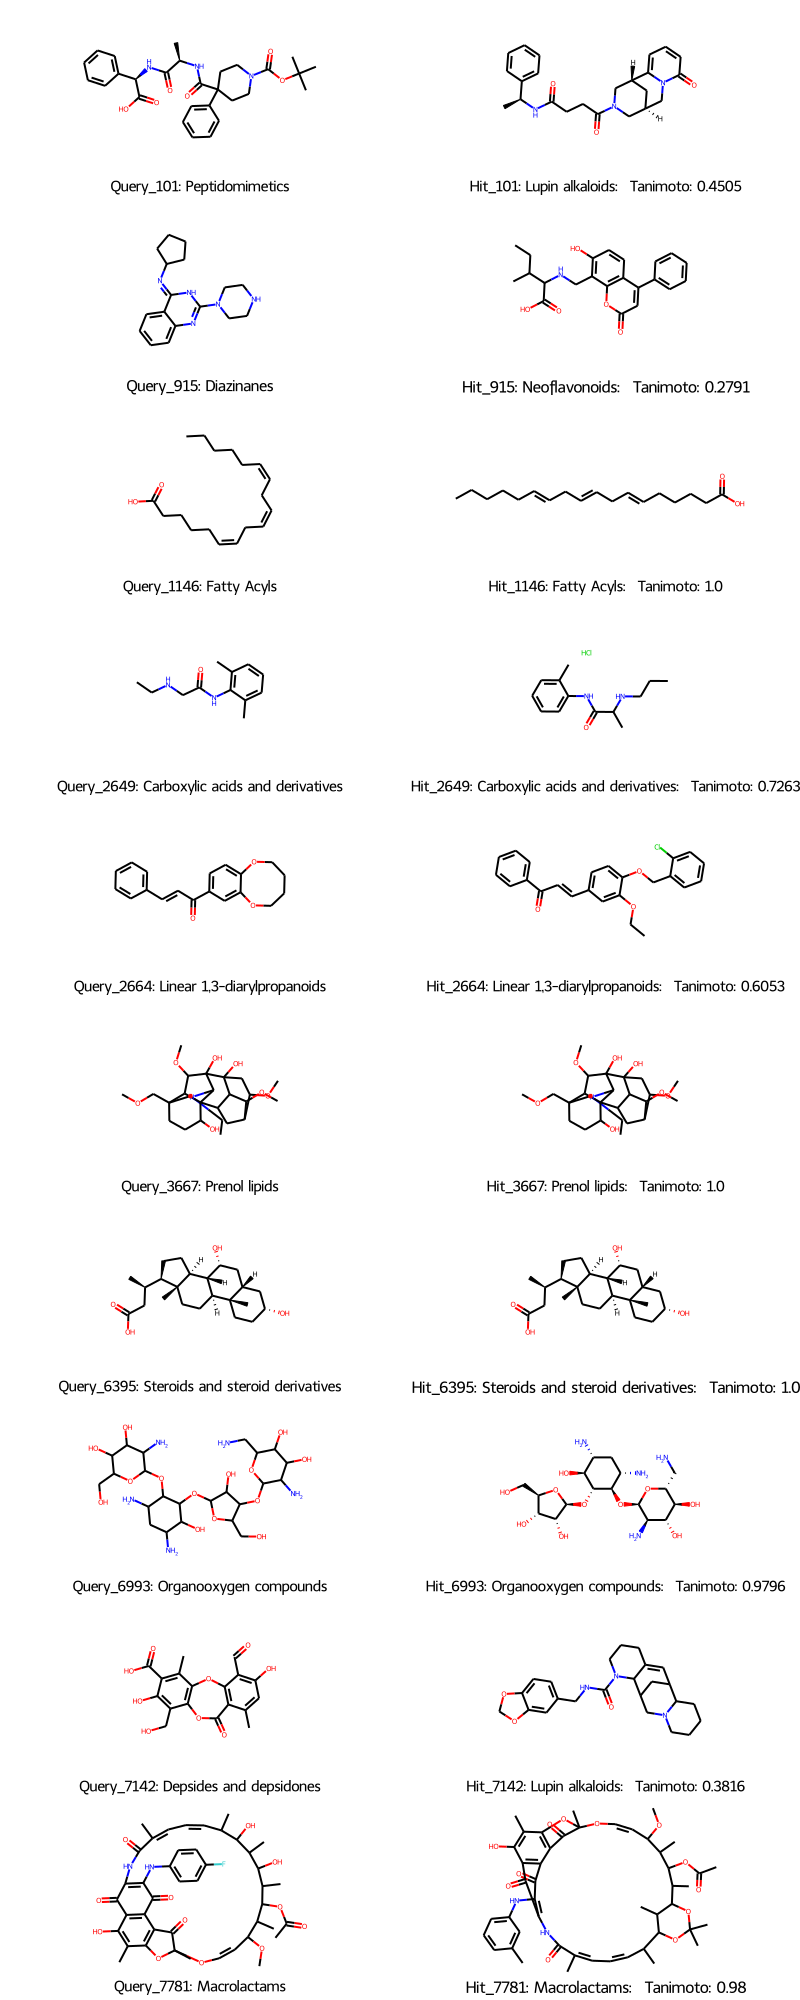

In [160]:
# cca common mols
cca_common_mols, cca_common_legends, cca_common_tanis = pick_hit_mols(hits_cca,train_df,test_df,
          group=test_common_list,
                              return_tanimoto=True)
Draw.MolsToGridImage(cca_common_mols,
                        molsPerRow=2, 
                        legends = cca_common_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

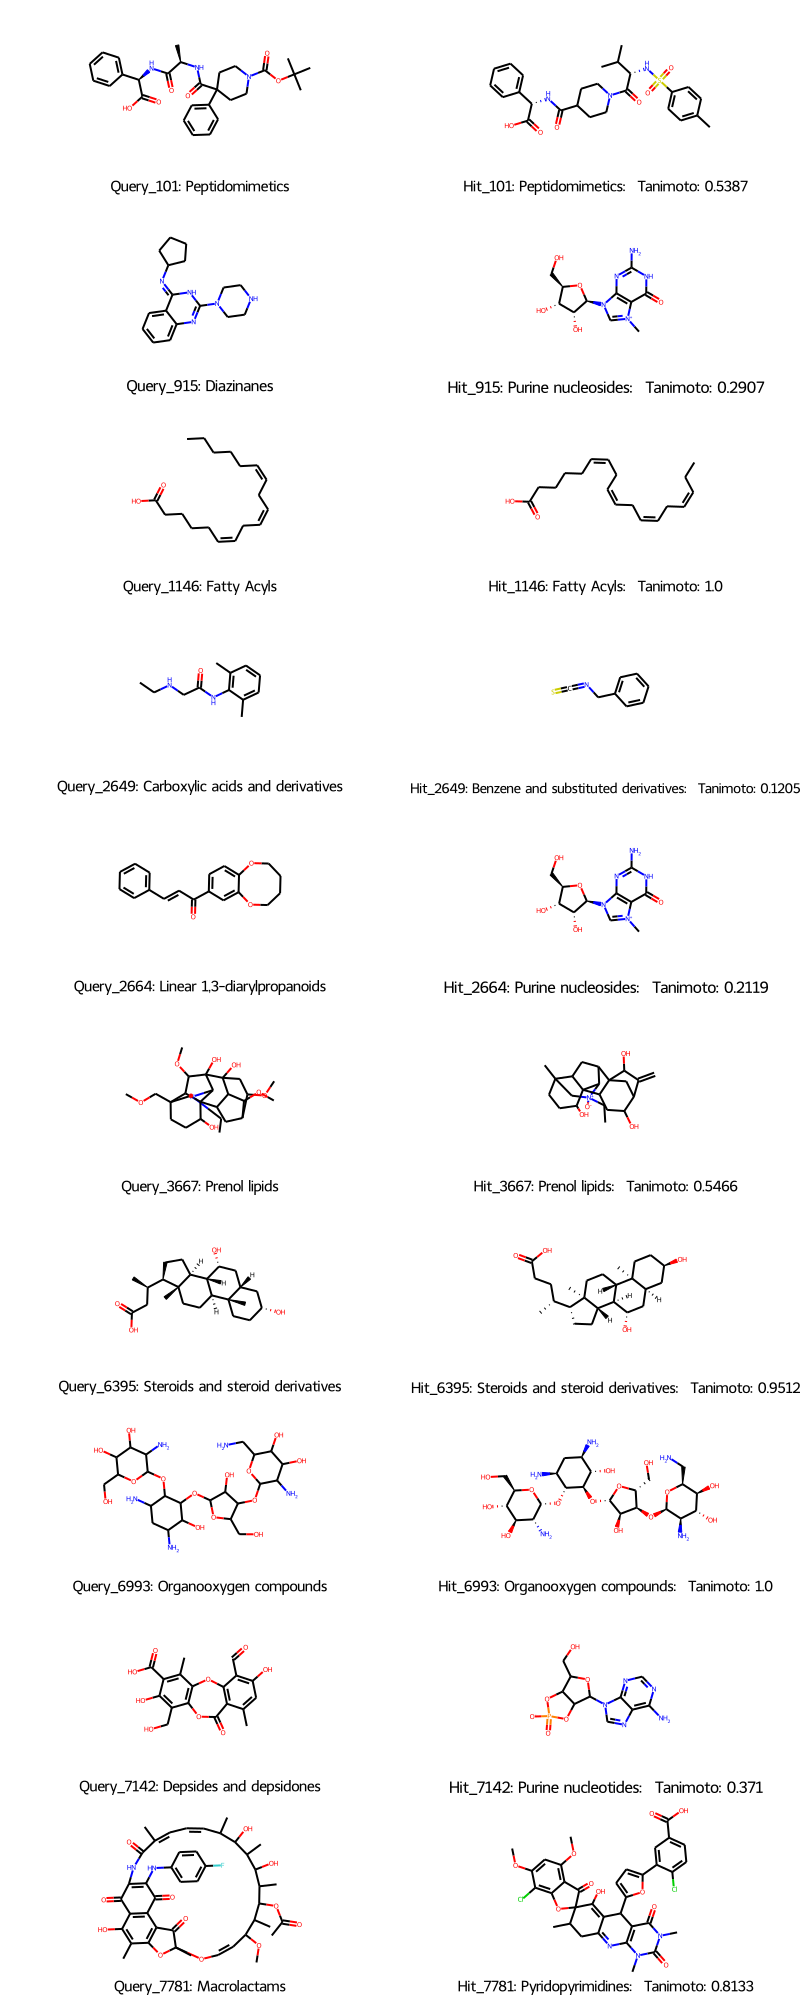

In [162]:
# dcca common mols
dcca_common_mols, dcca_common_legends, dcca_common_tanis = pick_hit_mols(hits_dcca,train_df,test_df,
          group=test_common_list,
                              return_tanimoto=True)
Draw.MolsToGridImage(dcca_common_mols,
                        molsPerRow=2, 
                        legends = dcca_common_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

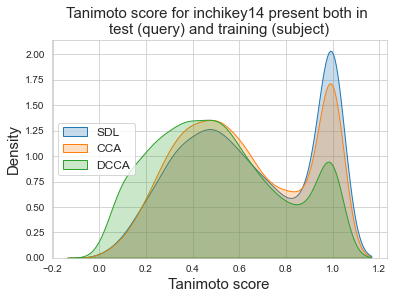

In [146]:
tanis = [sdl_common_tanis,cca_common_tanis,dcca_common_tanis]
legends = ['SDL', 'CCA','DCCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for inchikey14 present both in \ntest (query) and training (subject)'
fig_path = './common_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                     fig_path=fig_path,
                     savefig=True)

#### Never mind the codes below; you have reached the end of important codes

In [310]:
#random drawing for top 5 hits

# #randomly pick a query
# keys = random.sample(test_cca_corr_tanimotos.keys(),5)
# sample_dict = {key: test_cca_corr_tanimotos[key] for key in keys}

# #draw select top 5 hits
# all_mols = []
# #scores = []
# mol_classes = []
# #os.chdir('../compounds')
# for query_index, values in tqdm(sample_dict.items()):
#     top_hits = np.sort(values)[:5]
#     tanimotos = []
    
#     #draw the query
    
#     query_smile= val_df['smiles'].iloc[query_index]
#     query_class = val_df['cf_class'].iloc[query_index]
#     if type(query_class) == float:
#         query_class = 'NAN'
#         classes = [f'Query:\t{query_class}',]
#     classes = [f'QUERY:\t{query_class}',]
#     query = Chem.MolFromSmiles(query_smile)
#     #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
#     #Draw.MolsToGridImage(query)
#     #draw top 5 hits
#     subjects = [query,]
#     for hit_index, hit in enumerate(top_hits):
#         subject_index = values.index(hit)
#         subject_smile = train_df['smiles'].iloc[subject_index]
        
        
#         subject = Chem.MolFromSmiles(subject_smile)
#         subjects.append(subject)
#         #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
#         cl = train_df['cf_class'].iloc[subject_index]
#         if type(cl) == float:
#             cl = 'NAN'
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         else:
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         #check tanimotos for the random selections
#         tanimotos.append(tanimoto(query_smile,subject_smile))
#    # scores.append([(query_index,query_class),tanimotos])
#     all_mols.append(subjects)
#     mol_classes.append(classes)


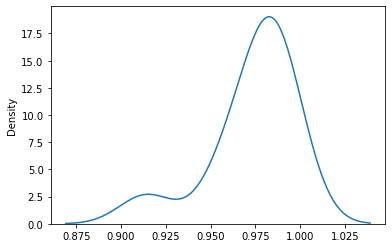

In [312]:

    
ax=sns.kdeplot(x=corr,shade=False)

In [ ]:
for key, values in sample_dict.items():
    print(key,max(values))
    print(np.sort(values)[::-1][0:5])